<h3>Notes</h3>

- Note that we don't need to specify the number of rows in the **input** or **output layer**. We only need to specify the number of units (i.e., the number of columns / dimensions). The number of rows (samples) is determined by the number of input samples we pass to the model.
- Note that **Dense** layers (fully connected layers) in neural networks are designed to process 1D vectors. When using convolutional layer in the NN, the output will be a 3D tensor. This 3D tensors needs to be flattened into a 1D vector before passing it to a Dense layer.
- Note that this goes the other way around as well; convolutional layers expect 3D inputs.
- So if you are using first convolutional layers, then dense layers, and again convolutional layers, you'll have to reshape the data accordingly.
- Note that when defining the input_shape in the input layer in a 'Sequential' model, you only need to pass the dimensions that correspond to the number of *time steps* and the number of *features*.
- The 'rate' argument of the **Dropout** function is the probability of shutting a neuron off during **training**. Note that 'rate' is not deterministic. If $\, \text{rate}=0.5, \,$ it does not mean that $\, 50\% \,$ of the neurons necessarily get shut down, but rather that each individual neuron within a layer is going to be shut down with a probability of $\, 0.5. \,$
- Note that **Dropout** is not applied during inference (prediction).
- Note that **Dropout** is applied to the layer preceding the Dropout() function call. For example, if your architecture is as follows: $\, \text{Dense1} \, \boldsymbol{\rightarrow} \, \text{Dropout} \, \boldsymbol{\rightarrow} \, \text{Conv1}, \,$ then Dropout will be applied to the outputs of the $\, \text{Dense1} \,$ layer.

Regarding the *batch_size* argument of the *fit* function. A **batch** is a subset of the training data that is used to train the model in one iteration of the training process. In our case, we have 1382 samples. These samples are divided into so-called **mini-batches** according to the size defined by the *batch_size* argument. In the *model_1* above, a batch_size of 32 was used. This means that there will be $\, 1382 \, // \, 32 = 43 \,$ full-sized mini-batches of size 32, and since $\, 1382 \, / \, 32 = 43.1875, \,$ the last mini-batch will be smaller. During the training process within each **epoch**, the model sees the entire dataset once. This means that there will be **44** iterations during one epoch. After each iteration (i.e., after processing one mini-batch of size 32), forward propagation and backward propagation is performed, leading to an update of the model weights.

<br>

In [47]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import he_normal, glorot_uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualization_utility import plot_data
import h5py
import os
import sys

In [2]:
print(tf.__version__)

2.15.0


In [3]:
# Folder where the input and output data are located
NN_data_path = "/fmi/projappl/project_2004400/jamin/data/libradtran_data/NN_data/"

In [4]:
X = pd.read_csv(NN_data_path + "inputs.csv", index_col=0)

In [5]:
def load_HDF5(folder_path: str, file_name: str):
    """
    Reads in the output data for the NN model.
    
    Args:
        folder_path: path to the folder containing the output data
        file_name: name of the output data file
        
    Returns:
        output_data: a NumPy array (tensor) containing the output data.
    """
    with h5py.File(name=folder_path+file_name, mode="r") as hf:
        data = hf["output_data"][:]
    return data

In [6]:
Y = load_HDF5(NN_data_path, "outputs_subset.h5")

In [7]:
print(f"Input (X) shape: {X.shape}")
print(f"Output (Y) shape: {Y.shape}")

Input (X) shape: (1728, 54)
Output (Y) shape: (1728, 235002, 8)


- Note that the 8 columns of **Y** correspond to these variable (in this order): tdir_down, tdif_down, tdir_up, tdif_up, spherical_albedo, edir, edif, path_rad.
- The order can be seen from the *create_subset* function in [THIS](https://github.com/monsieurformule/SummerProject/blob/main/code-files/Generate_NN_outputs.ipynb) notebook.

Note that there are **1728** *matrices*, where each matrix of shape $\, (235002, 8) \,$ corresponds to one row in the inputs matrix. This leaves us with two choices:

**1)** Build a NN where each input row predicts a matrix of shape $\, (235002, 8). \,$ \
**2)** Build **8** separate NNs, where each NN is taught to predict one vector of shape $\, (235002, 1). \,$

In this notebook, we'll build **8** separate neural networks that each predicts a different feature of shape $\, (235002, 1). \,$

<h3>Preparing the data for the neural network(s)</h3>

In [8]:
X.head()

,atmosphere_file,sza,altitude,tau,2e-05,4e-05,6e-05,0.00012,0.00026,0.00062,...,324.0,372.0,426.0,487.0,554.0,628.0,710.0,802.0,902.0,1013.0
0,afglms_Q1_0,25.0,0.0,0.05,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
1,afglms_Q1_0,25.0,0.0,0.15,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
2,afglms_Q1_0,25.0,0.0,0.30,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
3,afglms_Q1_0,25.0,1.5,0.05,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
4,afglms_Q1_0,25.0,1.5,0.15,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135


- We don't need (or rather cannot use) the first column, which acts as an identifier for the inputs, in the NN.

In [9]:
X = X.drop("atmosphere_file", axis=1)

In [10]:
X.head()

,sza,altitude,tau,2e-05,4e-05,6e-05,0.00012,0.00026,0.00062,0.00164,...,324.0,372.0,426.0,487.0,554.0,628.0,710.0,802.0,902.0,1013.0
0,25.0,0.0,0.05,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
1,25.0,0.0,0.15,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
2,25.0,0.0,0.30,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
3,25.0,1.5,0.05,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135
4,25.0,1.5,0.15,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135


In [11]:
(X.dtypes.values == "float64").all()

True

In [12]:
type(X)

pandas.core.frame.DataFrame

- Notice that the inputs are still in the form of a Pandas DataFrame.
- We want to change the inputs into NumPy arrays for train / validation splits, and tf.tensors for the NN.

In [13]:
X = X.values

In [14]:
type(X)

numpy.ndarray

Next, we'll split the data into a (train | validation | test) split. To achieve this, we'll call sklearn's *train_test_split* function twice. The first call splits the data into a (train | temp) split. The second call splits the temp data into a  (validation | test) split.

In [15]:
# (X, Y) ==> (train | temp)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
# temp ==> (validation | test)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [17]:
print("########## Test data ##########")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print()
print("########## Validation data ##########")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")
print()
print("########## test data ##########")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

########## Test data ##########
X_train shape: (1382, 53)
Y_train shape: (1382, 235002, 8)

########## Validation data ##########
X_val shape: (173, 53)
Y_val shape: (173, 235002, 8)

########## test data ##########
X_test shape: (173, 53)
Y_test shape: (173, 235002, 8)


- $\, 80\% \,$ of the data is used in the training set
- $\, 10\% \,$ of the data is used in the validation set
- $\, 10\% \,$ of the data is used in the test set

In [18]:
# Scale the features for numerical stability

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

- *MinMaxScaler* converts all feature values to the closed range [0, 1] while preserving the original distribution.
- Note that the scaler is fit only on *X_train* to prevent data leakage.

In [19]:
# Convert the data to tf.tensors

scaled_X_train = tf.cast(scaled_X_train, dtype=tf.float32)
scaled_X_val = tf.cast(scaled_X_val, dtype=tf.float32)
scaled_X_test = tf.cast(scaled_X_test, dtype=tf.float32)

Y_train = tf.cast(Y_train, dtype=tf.float32)
Y_val = tf.cast(Y_val, dtype=tf.float32)
Y_test = tf.cast(Y_test, dtype=tf.float32)

2024-07-24 15:22:01.121773: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


We still need to add an extra dimension for the input data in order to be able to use convolutional layers. Currently, the input data is of shape $ (\text{num_samples}, \, \text{num_features}). $
We'll modify the shape of the input data such that

$$ (\text{num_samples}, \, \text{num_features}) \quad \boldsymbol{\rightarrow} \quad (\text{num_samples}, \, \text{num_steps}, \, \text{features}), $$

where

- **num_samples:** the number of samples in the dataset
- **steps:** the length of the sequence (the number of discrete data points in our sequence, i.e., the number of features per sample) (this is analogous to the number of features in our original data when each feature is treated as a separate time step)
- **features:** the number of features to consider at each time step (we'll set this to 1)

This way, the reshaped input data will have each original feature treated as a time step in the sequence, with a single feature per time step.

In [20]:
# Adding an extra dimension to the input data
scaled_X_train = tf.expand_dims(scaled_X_train, axis=-1)
scaled_X_val = tf.expand_dims(scaled_X_val, axis=-1)
scaled_X_test = tf.expand_dims(scaled_X_test, axis=-1)

In [21]:
print(f"scaled_X_train min: {tf.reduce_min(scaled_X_train, axis=None).numpy()}")
print(f"scaled_X_train max: {tf.reduce_max(scaled_X_train, axis=None).numpy()}")
print(f"scaled_X_train shape: {scaled_X_train.shape}")
print()
print(f"scaled_X_val min: {tf.reduce_min(scaled_X_val, axis=None).numpy()}")
print(f"scaled_X_val max: {tf.reduce_max(scaled_X_val, axis=None).numpy()}")
print(f"scaled_X_val shape: {scaled_X_val.shape}")
print()
print(f"scaled_X_test min: {tf.reduce_min(scaled_X_test, axis=None).numpy()}")
print(f"scaled_X_test max: {tf.reduce_max(scaled_X_test, axis=None).numpy()}")
print(f"scaled_X_test min: {scaled_X_test.shape}")

scaled_X_train min: 0.0
scaled_X_train max: 1.0
scaled_X_train shape: (1382, 53, 1)

scaled_X_val min: 0.0
scaled_X_val max: 1.0
scaled_X_val shape: (173, 53, 1)

scaled_X_test min: 0.0
scaled_X_test max: 1.0
scaled_X_test min: (173, 53, 1)


Next, I'll be creating the **8** different outputs.

In [22]:
output_cols_in_order = ["tdir_down","tdif_down","tdir_up","tdif_up","spherical_albedo","edir","edif","path_rad"]
output_col_indices = {col_name: idx for idx, col_name in enumerate(output_cols_in_order)}

In [23]:
output_col_indices

{'tdir_down': 0,
 'tdif_down': 1,
 'tdir_up': 2,
 'tdif_up': 3,
 'spherical_albedo': 4,
 'edir': 5,
 'edif': 6,
 'path_rad': 7}

In [24]:
########## tdir_down ##########

Y_train_tdir_down = Y_train[:, :, output_col_indices["tdir_down"]]
Y_val_tdir_down = Y_val[:, :, output_col_indices["tdir_down"]]
Y_test_tdir_down = Y_test[:, :, output_col_indices["tdir_down"]]

print(f"Shape of Y_train_tdir_down: {Y_train_tdir_down.shape}")
print(f"Shape of Y_val_tdir_down: {Y_val_tdir_down.shape}")
print(f"Shape of Y_test_tdir_down: {Y_test_tdir_down.shape}")

Shape of Y_train_tdir_down: (1382, 235002)
Shape of Y_val_tdir_down: (173, 235002)
Shape of Y_test_tdir_down: (173, 235002)


In [25]:
########## tdif_down ##########

Y_train_tdif_down = Y_train[:, :, output_col_indices["tdif_down"]]
Y_val_tdif_down = Y_val[:, :, output_col_indices["tdif_down"]]
Y_test_tdif_down = Y_test[:, :, output_col_indices["tdif_down"]]

print(f"Shape of Y_train_tdif_down: {Y_train_tdif_down.shape}")
print(f"Shape of Y_val_tdif_down: {Y_val_tdif_down.shape}")
print(f"Shape of Y_test_tdif_down: {Y_test_tdif_down.shape}")

Shape of Y_train_tdif_down: (1382, 235002)
Shape of Y_val_tdif_down: (173, 235002)
Shape of Y_test_tdif_down: (173, 235002)


In [26]:
########## tdir_up ##########

Y_train_tdir_up = Y_train[:, :, output_col_indices["tdir_up"]]
Y_val_tdir_up = Y_val[:, :, output_col_indices["tdir_up"]]
Y_test_tdir_up = Y_test[:, :, output_col_indices["tdir_up"]]

print(f"Shape of Y_train_tdir_up: {Y_train_tdir_up.shape}")
print(f"Shape of Y_val_tdir_up: {Y_val_tdir_up.shape}")
print(f"Shape of Y_test_tdir_up: {Y_test_tdir_up.shape}")

Shape of Y_train_tdir_up: (1382, 235002)
Shape of Y_val_tdir_up: (173, 235002)
Shape of Y_test_tdir_up: (173, 235002)


In [27]:
########## tdif_up ##########

Y_train_tdif_up = Y_train[:, :, output_col_indices["tdif_up"]]
Y_val_tdif_up = Y_val[:, :, output_col_indices["tdif_up"]]
Y_test_tdif_up = Y_test[:, :, output_col_indices["tdif_up"]]

print(f"Shape of Y_train_tdif_up: {Y_train_tdif_up.shape}")
print(f"Shape of Y_val_tdif_up: {Y_val_tdif_up.shape}")
print(f"Shape of Y_test_tdif_up: {Y_test_tdif_up.shape}")

Shape of Y_train_tdif_up: (1382, 235002)
Shape of Y_val_tdif_up: (173, 235002)
Shape of Y_test_tdif_up: (173, 235002)


In [28]:
########## spherical_albedo ##########

Y_train_spherical_albedo = Y_train[:, :, output_col_indices["spherical_albedo"]]
Y_val_spherical_albedo = Y_val[:, :, output_col_indices["spherical_albedo"]]
Y_test_spherical_albedo = Y_test[:, :, output_col_indices["spherical_albedo"]]

print(f"Shape of Y_train_spherical_albedo: {Y_train_spherical_albedo.shape}")
print(f"Shape of Y_val_spherical_albedo: {Y_val_spherical_albedo.shape}")
print(f"Shape of Y_test_spherical_albedo: {Y_test_spherical_albedo.shape}")

Shape of Y_train_spherical_albedo: (1382, 235002)
Shape of Y_val_spherical_albedo: (173, 235002)
Shape of Y_test_spherical_albedo: (173, 235002)


In [29]:
########## edir ##########

Y_train_edir = Y_train[:, :, output_col_indices["edir"]]
Y_val_edir = Y_val[:, :, output_col_indices["edir"]]
Y_test_edir = Y_test[:, :, output_col_indices["edir"]]

print(f"Shape of Y_train_edir: {Y_train_edir.shape}")
print(f"Shape of Y_val_edir: {Y_val_edir.shape}")
print(f"Shape of Y_test_edir: {Y_test_edir.shape}")

Shape of Y_train_edir: (1382, 235002)
Shape of Y_val_edir: (173, 235002)
Shape of Y_test_edir: (173, 235002)


In [30]:
########## edif ##########

Y_train_edif = Y_train[:, :, output_col_indices["edif"]]
Y_val_edif = Y_val[:, :, output_col_indices["edif"]]
Y_test_edif = Y_test[:, :, output_col_indices["edif"]]

print(f"Shape of Y_train_edif: {Y_train_edif.shape}")
print(f"Shape of Y_val_edif: {Y_val_edif.shape}")
print(f"Shape of Y_test_edif: {Y_test_edif.shape}")

Shape of Y_train_edif: (1382, 235002)
Shape of Y_val_edif: (173, 235002)
Shape of Y_test_edif: (173, 235002)


In [31]:
########## path_rad ##########

Y_train_path_rad = Y_train[:, :, output_col_indices["path_rad"]]
Y_val_path_rad = Y_val[:, :, output_col_indices["path_rad"]]
Y_test_path_rad = Y_test[:, :, output_col_indices["path_rad"]]

print(f"Shape of Y_train_path_rad: {Y_train_path_rad.shape}")
print(f"Shape of Y_val_path_rad: {Y_val_path_rad.shape}")
print(f"Shape of Y_test_path_rad: {Y_test_path_rad.shape}")

Shape of Y_train_path_rad: (1382, 235002)
Shape of Y_val_path_rad: (173, 235002)
Shape of Y_test_path_rad: (173, 235002)


<h3>Creating the baseline NN model</h3>

A *baseline* model is a simple model or an existing result that one sets up when beginning a machine learning experiment. The goal is to beat this baseline model with experimenting. In deep learning, there is almost infinite amount of architectures one could create. For this reason, one of the best ways to get started is to start with something simple and see if it works with your data, and just then introduce complexity to the model as required.

<h3>tdir_up</h3>

In [32]:
tdir_down_min = np.round(np.min(Y[:, :, output_col_indices["tdir_down"]].ravel()), 5)
tdir_down_max = np.round(np.max(Y[:, :, output_col_indices["tdir_down"]].ravel()), 5)
print(f"Range of tdir_down: [{tdir_down_min}, {tdir_down_max}]")

Range of tdir_down: [0.0, 0.92564]


In [98]:
def model_1(X_train, Y_train, X_val, Y_val, num_epochs: int, batch_size: int, output_var_name):
    """
    Builds, compiles, fits, and plots the learning curve of a NN.
    
    Args:
    X -- the input dataset
    Y -- the output dataset
    num_epochs -- the number of epochs
    batch_size -- the batch size
    val_data -- validation data to be used in the training process of the NN
    output_var_name -- name of the output variable that the NN model predicts
    
    Prints:
    - train MSE
    - validation MSE
    
    Returns:
    model -- the fitted neural network model.
    """
    #tf.random.set_seed(42)
    
    # Architecture of the NN model
    model = Sequential([
        
        Input(shape=(53, 1)),
        
        # Hidden layer 1
        Conv1D(filters=10, kernel_size=3, kernel_initializer=he_normal(), activation="relu"),
        
        # Hidden layer 2
        MaxPool1D(pool_size=2, strides=None),
        
        # Flatten the 3D tensor into a 1D vector
        Flatten(),
        
        # Hidden layer 3
        Dense(units=60, kernel_initializer=he_normal(), activation="relu"),
        
        # Hidden layer 4
        Dense(units=60, kernel_initializer=he_normal(), activation="relu"),

        # Output layer
        Dense(units=235002, kernel_initializer=glorot_uniform(), activation="linear"),
    ])
    
    # Compile the model
    model.compile(loss=MSE,
                  optimizer=Adam(),
                  metrics=["mse"])
    
    # Fit the model
    loss_history = model.fit(X_train, 
                             Y_train, 
                             epochs=num_epochs, 
                             batch_size=batch_size, 
                             validation_data=(X_val, Y_val))
    
    # Train error
    train_loss, train_mse = model.evaluate(X_train, Y_train)
    
    # Validation error
    val_loss, val_mse = model.evaluate(X_val, Y_val)
    
    print("########################################")
    print(f"Train MSE: {train_mse}")
    print(f"Validation MSE: {val_mse}")
    print("########################################")
    
    def plot_learning_curve(loss_history):
        num_epochs = len(loss_history.epoch)
        fig, ax = plt.subplots(figsize=(8,6), dpi=100)
        ax.plot(np.arange(1, num_epochs+1), loss_history.history["loss"], color="blue", label="train loss", linestyle="dashed")
        ax.plot(np.arange(1, num_epochs+1), loss_history.history["val_loss"], color="black", label="validation loss")
        ax.set_title(f"Learning curve for {output_var_name}", size=12)
        ax.set_xlabel("Number of epochs", size=12)
        ax.set_ylabel("Cost function value", size=12)
        plt.legend();
        
    # Plot the learning curve
    plot_learning_curve(loss_history)
    
    # Arttu's plot
    plot_data(y_true=Y_val,
              y_pred=model.predict(X_val),
              title="Emulator result",
              x_label=f"{output_var_name} true",
              y_label=f"{output_var_name} emulated",
              error_bar_on=True)
    
    return model

Epoch 1/10
44/44 [==============================] - 3s 44ms/step - loss: 0.1871 - mse: 0.1871 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 2/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 3/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 8.9988e-04 - val_mse: 8.9988e-04
Epoch 7/10
44/44 [==============================] - 2s 43ms/step - loss: 7.8016e-04 - mse: 7.8016e-04 - val_loss: 5.0338e-04 - val_mse: 5.0338e-04
Epoch 8/10
44/44 [==============================] - 2s 41ms

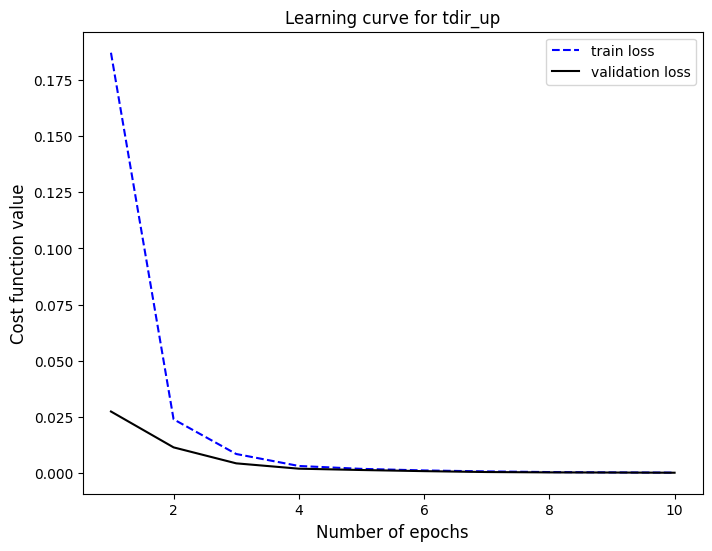

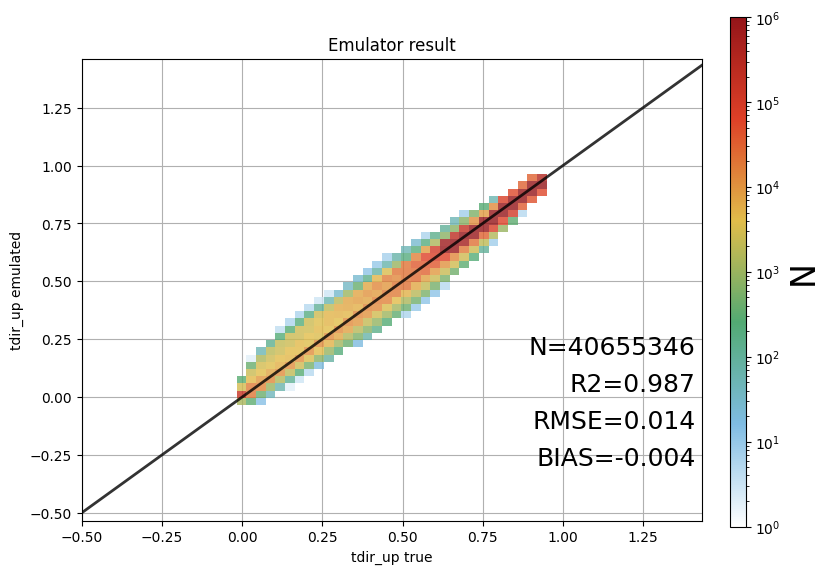

In [99]:
model_1_tdir_down = model_1(X_train=scaled_X_train, 
                            Y_train=Y_train_tdir_up,
                            X_val=scaled_X_val,
                            Y_val=Y_val_tdir_up,
                            num_epochs=10,
                            batch_size=32,
                            output_var_name="tdir_up")